# CIBUSmod multi-processing example
This notebook privides an example of how to use multiple processes to run multiple scenarios/years faster.

### Import libraries
Add directory with the CIBUSmod modules to path to be able to import

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod'))

Import CIBUSmod and packages for handling data and plotting

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Set up scenario and modules

Instantiate a `Session` object and define scenarios in the same way as in the single-processing case. To make multi-processing work we need to instantiate the CIBUSmod modules and define the calculations in a separate file. Here we use `multi_proc.py` for this. This file defines a function `do_run()`  which performes the calculations. It is important that the `name` and `data_path` parameters to create `Session` object in `multi_proc.py` matches the `name` and `data_path` defined below in this notebook.

In [3]:
# Create session
session = cm.Session(
    name = 'phd_lab',
    data_path = '../CIBUSmod/data',
    data_path_scenarios='',
    data_path_output=''
)

In [5]:
years = list(range(2020,2050+1,10))

session.add_scenario(
    name = 'Baseline',
    scenario_workbooks = ['baseline'],
    years = years
)

session.add_scenario(
    name = 'PhD scn',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = years
)

session.add_scenario(
    name = '+demand',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions']
)

session.add_scenario(
    name = '+crops',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction']
)

session.add_scenario(
    name = '+cattle',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd']
)

session.add_scenario(
    name = '+pigs',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd']
)

session.add_scenario(
    name = '+poultry',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd', 'BroilerHerd', 'LayerHerd']
)

session.add_scenario(
    name = '+waste',
    scenario_workbooks = ['baseline', 'scenario_lab'],
    years = '2050',
    modules = ['DemandAndConversions', 'CropProduction', 'CattleHerd'
              'PigHerd', 'BroilerHerd', 'LayerHerd', 'WasteAndCircularity']
)

A scenario with the name 'Baseline' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name 'PhD scn' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+demand' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+crops' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+cattle' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+pigs' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+poultry' already exists use .update_scenario() or .remove_scenario() instead.
A scenario with the name '+waste' already exists use .update_scenario() or .remove_scenario() instead.


### Run calculations
The code below initiates a process pool that executes the model runs. The `max_workers` paramter to `ProcessPoolExecutor()` defines the maximum number of concurrent processes. The ideal value for this will depend on the computer. The code will print a message every time a scenario run has finnished and if a scenario run fails it will print an error message.

In [7]:
# Import
from concurrent.futures import ProcessPoolExecutor, as_completed
from multi_proc import do_run

# Create list of scenarios/years to run
# runs = [(s,y) for s, y in session.iterate('all')]
runs = [(s,y) for s, y in session.iterate(['PhD scn','+demand', '+crops', '+cattle', '+pigs', '+poultry', '+waste'])]
runs

[('Baseline', '2020'),
 ('Baseline', '2030'),
 ('Baseline', '2040'),
 ('Baseline', '2050'),
 ('PhD scn', '2020'),
 ('PhD scn', '2030'),
 ('PhD scn', '2040'),
 ('PhD scn', '2050'),
 ('+demand', '2050'),
 ('+crops', '2050'),
 ('+cattle', '2050'),
 ('+pigs', '2050'),
 ('+poultry', '2050'),
 ('+waste', '2050')]

In [8]:
%%time
# Do the multi-processing
with ProcessPoolExecutor(max_workers=8) as executor:
    
    futures = {executor.submit(do_run, session, scn_year) : scn_year for scn_year in runs}

    for future in as_completed(futures):
    
        scn, year = futures[future]
           
        try:
            t = future.result()
        except Exception as ee:
            print(f'(!!!) {scn}, {year} failed with the exception: {ee}')
        else:
            m = int(t/60)
            s = int(round(t - m*60))
            print(f'{scn}, {year} finished successfully in {m}min {s}s')
                    

PhD scn, 2050 finished successfully in 4min 19s
PhD scn, 2020 finished successfully in 4min 19s
Baseline, 2050 finished successfully in 4min 20s
Baseline, 2020 finished successfully in 4min 32s
PhD scn, 2030 finished successfully in 4min 37s
PhD scn, 2040 finished successfully in 4min 39s
Baseline, 2040 finished successfully in 4min 40s
Baseline, 2030 finished successfully in 4min 42s
+crops, 2050 finished successfully in 2min 47s
+demand, 2050 finished successfully in 3min 5s
+pigs, 2050 finished successfully in 3min 12s
+cattle, 2050 finished successfully in 3min 28s
+poultry, 2050 finished successfully in 3min 12s
+waste, 2050 finished successfully in 3min 20s
CPU times: total: 15.6 ms
Wall time: 8min 8s


## Plot output
Here are some example output plots.

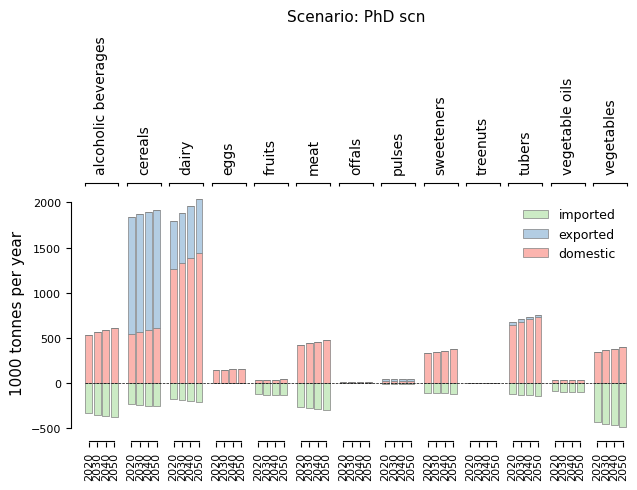

In [21]:
style = {
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'bar_width' : 0.8,
    'group_spacing' : 1,
    'grouplabels_fontsize' : 10,
    'ticklabels_fontsize' : 8,
    'totmarker' : 'none',
    'ylabel' : '1000 tonnes per year'
}

plot_data = (
    session.get_attr(
        module='D',
        attr='food_demand_to_processing',
        groupby=['origin','food_group']
    ).add(
        session.get_attr(
            module='D',
            attr='export_demand',
            groupby=['origin','food_group']
        ).rename(columns={'domestic':'exported'}),
        fill_value = 0
    )
    .stack()
    .fillna(0)
)/1000000
plot_data.loc[:,'imported'] = -plot_data.loc[:,'imported']

fig, ax = plt.subplots(figsize=(7,3))
cm.plot.bar(plot_data.loc['PhD scn'], group_levels='food_group', grouplabels_vertical=True, grouptitle='Scenario: PhD scn', ax=ax, **style)
plt.show()

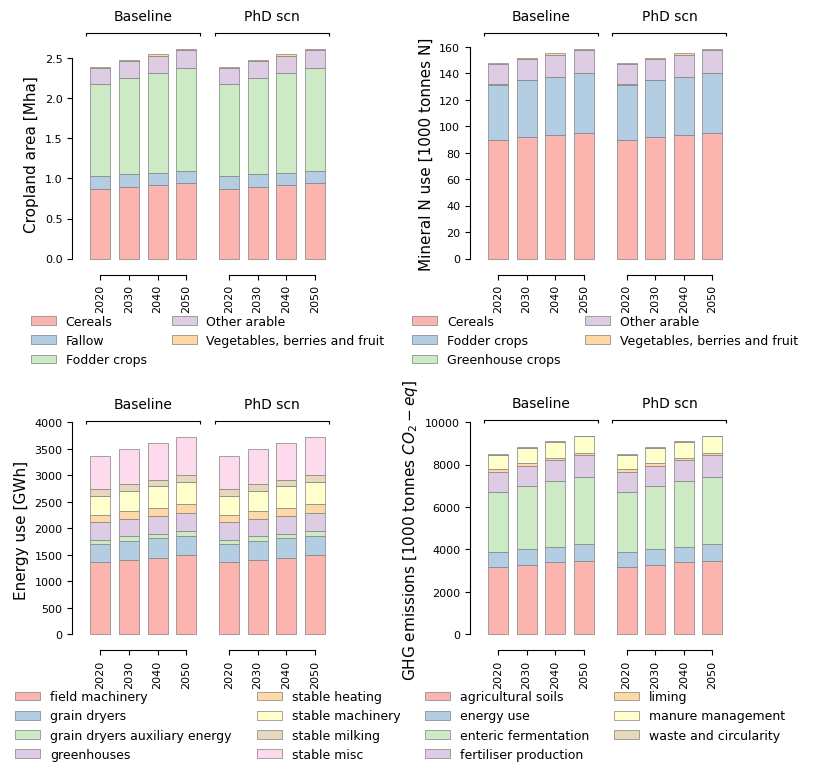

In [10]:
style = {
    'stacked' : True,
    'cmap' : 'Pastel1',
    'edgecolor' : 'grey',
    'ticklabels_fontsize' : 8,
    'bar_width' : 0.7
}

fig, axs = plt.subplots(2,2, figsize=(8,8))

# Land use --->
plot_data = session.get_attr('C','area',{'crop':'crop_group2'}, scn=['Baseline', 'PhD scn'])/1000000

# Cropland
ax = axs[0,0]
plot.bar(
    plot_data.drop(['Semi-natural grasslands','Greenhouse crops'], axis=1),
    **style,
    ax=ax,
    group_levels='scn',
    ylabel='Cropland area [Mha]'
)

# Mineral N use --->
ax = axs[0,1]
plot.bar(
    (session.get_attr('C','fertiliser.mineral_N',{'crop':'crop_group2'}, scn=['Baseline', 'PhD scn'])/1000000),
    **style,
    ax=ax,
    group_levels='scn',
    ylabel='Mineral N use [1000 tonnes N]'
)

# Energy use --->
ax = axs[1,0]
plot.bar(
    pd.concat([
        session.get_attr('C','energy_use','activity', scn=['Baseline', 'PhD scn']),
        session.get_attr('A','energy_use','activity', scn=['Baseline', 'PhD scn'])
    ], axis=1)/1000000,
    **style,
    ax=ax,
    group_levels='scn',
    ylabel='Energy use [GWh]'
)

# GHG emissions
ax = axs[1,1]
plot_data = (
    cm.get_GHG(session, scn=['Baseline', 'PhD scn'])
    .T.groupby('process').sum().T
)/1000000
plot.bar(
    plot_data,
    **style,
    ax=ax,
    group_levels='scn',
    ylabel=r'GHG emissions [1000 tonnes $CO_{2}-eq$]'
)

for ax in axs.flatten():
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.2), fontsize=9, frameon=False)

plt.tight_layout()
plt.show()

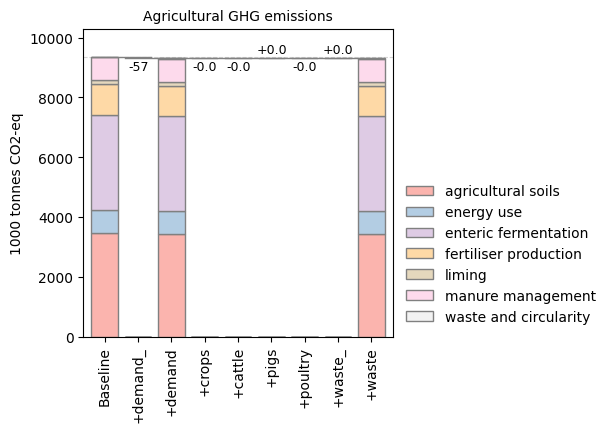

In [11]:
fig, ax = plt.subplots(figsize=(4,4))

plot_data1 = (
    cm.get_GHG(session, scn=['Baseline','+demand', '+crops', '+cattle', '+pigs', '+poultry', '+waste'], years='2050')
    .T.groupby('process').sum().T
    .droplevel('year')
)/1000000

plot.waterfall(
    data=plot_data1,
    ax=ax,
    breaks = ['+demand'],
    cmap='Pastel1',
    edgecolor='grey',
    width=0.8,
    label='absolute',
    label_size=9
)

ax.axhline(y=plot_data1.sum(axis=1).loc['Baseline'], xmin=0, xmax=1, zorder=0, linestyle='--', linewidth=0.8, color='lightgrey')

ax.set_title('Agricultural GHG emissions', size=10)
ax.tick_params(axis='y', which='major')
ax.set_xlabel('')
ax.set_ylabel('1000 tonnes CO2-eq')
ax.set_ylim(top=plot_data1.sum(axis=1).max()*1.1)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0), frameon=False)

plt.show()